In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime


In [2]:

msg_files = glob("C:/Users/macri/Desktop/smh/*message*.csv")
lob_files = glob("C:/Users/macri/Desktop/smh/*order*.csv")

d0 = datetime(2020,1,2)
dfs = []
for day, file in enumerate(np.sort(msg_files)[:]):
    te = pd.read_csv(file, header=None, low_memory=False)
    te['Day'] = d0 + BDay(day)
    dfs.append(te)
df_msg = pd.concat(dfs)

print("{0:0.2f} million observations".format(len(df_msg)/10**6))
df_msg.columns = ['Time', 'Event', 'ID', 'Size', 'Price', 'Direction', '?', 'Day']
df_msg = df_msg.drop(['?'], axis=1)
df_msg['Execution'] = np.where(df_msg['Event'].isin([4,5]), 1, 0)
dfs = []
for file in np.sort(lob_files)[:]:
    te = pd.read_csv(file, header=None)
    dfs.append(te)
df_lob  = pd.concat(dfs)
cols = np.ravel([['AP%d'%level, 'AS%d'%level, 'BP%d'%level, 'BS%d'%level] for level in [1]])
df_lob.columns = cols
print("{0:0.2f} million observations".format(len(df_lob)/10**6))
df_lob = df_lob/10_000
df_lob.head()

smh = (df_lob['AP1'].to_numpy() + df_lob['BP1'].to_numpy())/2
smh = smh

0.05 million observations
0.05 million observations


In [3]:

msg_files = glob("C:/Users/macri/Desktop/intc/*message*.csv")
lob_files = glob("C:/Users/macri/Desktop/intc/*order*.csv")

d0 = datetime(2020,1,2)
dfs = []
for day, file in enumerate(np.sort(msg_files)[:]):
    te = pd.read_csv(file, header=None, low_memory=False)
    te['Day'] = d0 + BDay(day)
    dfs.append(te)
df_msg = pd.concat(dfs)

print("{0:0.2f} million observations".format(len(df_msg)/10**6))
df_msg.columns = ['Time', 'Event', 'ID', 'Size', 'Price', 'Direction', '?', 'Day']
df_msg = df_msg.drop(['?'], axis=1)
df_msg['Execution'] = np.where(df_msg['Event'].isin([4,5]), 1, 0)
dfs = []
for file in np.sort(lob_files)[:]:
    te = pd.read_csv(file, header=None)
    dfs.append(te)
df_lob  = pd.concat(dfs)
cols = np.ravel([['AP%d'%level, 'AS%d'%level, 'BP%d'%level, 'BS%d'%level] for level in [1]])
df_lob.columns = cols
print("{0:0.2f} million observations".format(len(df_lob)/10**6))
df_lob = df_lob/10_000
df_lob.head()

intc = (df_lob['AP1'].to_numpy() + df_lob['BP1'].to_numpy())/2
intc = intc[:len(smh)]

0.31 million observations
0.31 million observations


In [4]:
smh  = smh[:len(intc)]
intc = intc

from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assuming you have two time series variables x and y
x = smh
y = intc

# Combine the variables into a 2D array
data = np.column_stack((x, y))

# Perform the Johansen cointegration test
result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Extract the test statistics and critical values
test_statistic = result.lr1[0]
critical_values = result.cvt[:, 0]  # Assuming you want the critical values for the 0th eigenvalue

# Compare the test statistic with the critical values to determine cointegration
is_cointegrated = test_statistic > critical_values

# Print the results
print("Is cointegrated:", is_cointegrated)

Is cointegrated: [ True  True]


In [5]:
from statsmodels.tsa.vector_ar.var_model import VAR

# Combine the price series of Apple and Amazon into a single DataFrame
price_df = pd.DataFrame({'SMH': (smh), 'INTC': (intc)})

# Fit the VAR model
model = VAR(price_df)
results = model.fit()

# Print the summary of the model
print(results.summary()), results.params

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, Jul, 2024
Time:                     04:50:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -24.7349
Nobs:                     50975.0    HQIC:                  -24.7357
Log likelihood:           485804.    FPE:                1.80842e-11
AIC:                     -24.7360    Det(Omega_mle):     1.80821e-11
--------------------------------------------------------------------
Results for equation SMH
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.106113         0.029875           -3.552           0.000
L1.SMH          0.996836         0.000354         2818.608           0.000
L1.INTC         0.009604         0.001553            6.183           0.000

Results fo

(None,
               SMH      INTC
 const   -0.106113  0.005354
 L1.SMH   0.996836  0.000060
 L1.INTC  0.009604  0.999682)

In [6]:
A = results.params[:1].values
B = results.params[1:].values

eye = np.eye(2)
Dt = 1

k = (eye - B)
theta = A@np.linalg.inv(k)
k, theta # k is the cointegration matrix, theta is the mean-reversion level

(array([[ 3.16351437e-03, -6.01845425e-05],
        [-9.60435487e-03,  3.18456609e-04]]),
 array([[41.05512143, 24.57130413]]))

In [7]:
eigenvalues, eigenvectors = np.linalg.eig(k)
kappa_tilde = np.diag(eigenvalues)

kappa_tilde 

array([[0.00335394, 0.        ],
       [0.        , 0.00012803]])

In [8]:
eigenvectors @ kappa_tilde @ np.linalg.inv(eigenvectors) # ritrovi k

array([[ 3.16351437e-03, -6.01845425e-05],
       [-9.60435487e-03,  3.18456609e-04]])

In [9]:
S_tilde = np.linalg.inv(eigenvectors)@np.stack([smh, intc], axis=1).T
S_tilde # cointegrated series

array([[127.03213995, 126.95438912, 126.95438912, ..., 126.24844084,
        126.24844084, 126.24844084],
       [145.67010749, 145.5909557 , 145.5909557 , ..., 144.97270509,
        144.97270509, 144.97270509]])

In [10]:
#demonstrates that you can recover either S_tilde_1 or S_tilde_2 from kappa_tilde, and that you can recover the initial series from S_tilde
S_tilde_1_hat = np.linalg.inv(eigenvectors)[0,0]*smh + np.linalg.inv(eigenvectors)[0,1]*intc ###################################
S_tilde_2_hat = np.linalg.inv(eigenvectors)[1,0]*smh + np.linalg.inv(eigenvectors)[1,1]*intc
intc_hat = eigenvectors[0,0]*S_tilde[0] + eigenvectors[0,1]*S_tilde[1]
smh_hat  = eigenvectors[1,0]*S_tilde[0] + eigenvectors[1,1]*S_tilde[1]

In [11]:
np.linalg.inv(eigenvectors)

array([[ 3.12241481, -0.06190813],
       [ 2.97784056,  0.94115488]])

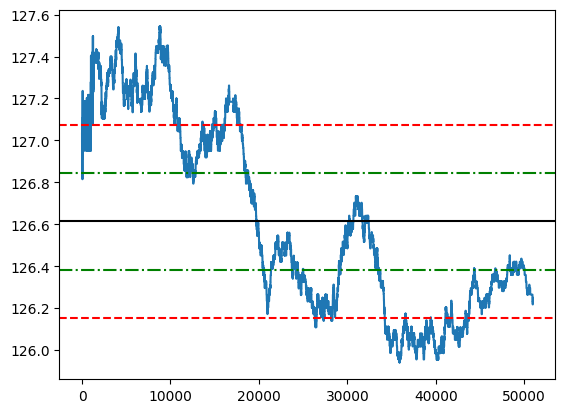

In [12]:
#plt.plot(S_tilde_1_hat)
plt.plot(S_tilde[0])
plt.axhline(S_tilde[0].mean(), color='black')
plt.axhline(S_tilde[0].mean() + S_tilde[0].std(), color='red', linestyle='--')
plt.axhline(S_tilde[0].mean() - S_tilde[0].std(), color='red', linestyle='--')
plt.axhline(S_tilde[0].mean() + 0.5*S_tilde[0].std(), color='green', linestyle='-.')
plt.axhline(S_tilde[0].mean() - 0.5*S_tilde[0].std(), color='green', linestyle='-.')
plt.show()

In [13]:
S_tilde[0].mean(),S_tilde[0].mean() + 1.5*S_tilde[0].std(), S_tilde[0].mean() -1.5* S_tilde[0].std()

(126.61320843438816, 127.30296920616719, 125.92344766260912)

In [21]:
import numpy as np
import matplotlib.pyplot as plt

es = (S_tilde[0] - S_tilde[0].mean()) / S_tilde[0].std() #2*(S_tilde[0] - S_tilde[0].min()) / (S_tilde[0].max() - S_tilde[0].min())-1

# Calculate the mean and standard deviation
mean = es.mean()
std = es.std()

# Create the matrix
matrix = np.zeros((len(es), 2))
matrix[:, 0] = es
matrix[:, 1] = mean

# Initialize the second column with zeros (or any placeholder)
a = []

j = 0
for i in range(len(es)):
    j +=1

    if es[i] >= (mean ):
        matrix[i, 1] = mean +  1*std
    if es[i] < (mean  ):
        matrix[i, 1] = mean -  1*std

# Assign the calculated values to the second column of the matrix
#matrix[:, 1] = a



In [22]:
S_tilde[0].mean(),S_tilde[0].std()

(126.61320843438816, 0.45984051451935737)

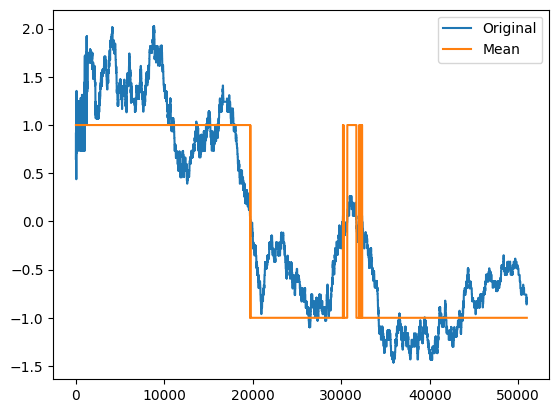

0.06649198052433175

In [23]:
plt.plot(matrix[:, 0], label='Original')
plt.plot(matrix[:, 1], label='Mean')
plt.legend()    
#plt.axvline(30_000, color='black')
plt.show()

matrix[:30_000, 1]

matrix[11415:12415, 0].std()

In [24]:
matrix[:,0].mean(), matrix[:,0].std()

(8.251751796335124e-15, 0.9999999999999998)

In [25]:
np.save('matrix.npy', matrix)

In [26]:
np.load('matrix.npy')

array([[ 0.91103654,  1.        ],
       [ 0.74195438,  1.        ],
       [ 0.74195438,  1.        ],
       ...,
       [-0.79324806, -1.        ],
       [-0.79324806, -1.        ],
       [-0.79324806, -1.        ]])

Trading strategy will be to buy if either trading signal $\tilde{S}^{1,2}_t$ goes down and to sell when the trading signal goes up, thresholds for up and down are the standard deviations of the signals.
Reward is thus:
$$ r_t = X_t + \beta_t (A S^\text{intc}_t + B S^\text{smh}_{t}) $$

where $X_t$ is the running cash and A, B are the elements in eigenvector matrix either (0,0) and (0,1) or the opposite, depending if the trading signal to follow is $\tilde{S}^{1}_t$ or $\tilde{S}^{2}_t$